In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import glob
import platform
import pathlib  
import os.path
import netCDF4 as nc
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.errors import RasterioIOError
from shapely.geometry import Point
import time
import json
from scipy.spatial import cKDTree
from concurrent.futures import ProcessPoolExecutor


In [2]:
cwd = pathlib.Path().resolve()
src = cwd.parent
data = src.parent.parent.parent
OS_type = platform.system()

if OS_type == 'Darwin':
    username = 'Mats '
    data_path = os.path.join(data, 'data_tana', 'catchments')
    shape_path = os.path.join(data, 'data_tana', 'catchments')
    results_path = os.path.join(data, 'data_tana', 'catchments', 'results')
    evaporation = os.path.join(data, 'data_tana', 'TAHMO', 'interpolated')
    
else:
    username = 'Mootje'
    data_path = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data', 'Satellite')
    shape_path = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data', 'Shapefiles','Mini_shapes')

print(f"Welcome {username}, have a wondeful day on your {OS_type} machine. Your data should be located in {data_path}")
print(data_path)

Welcome Mats , have a wondeful day on your Darwin machine. Your data should be located in /Users/matskerver/Documents/data_tana/catchments
/Users/matskerver/Documents/data_tana/catchments


In [3]:
# print(data_path)

# path_subcatchments = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data','Shapefiles', 'Mini_shapes')
# path_satellite = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data', 'Satellite')
# path_save_new_shapefiles = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data', 'subcatchments_chirps')

# shapefiles_fnames = os.path.join(path_subcatchments, '*.gpkg')
# shape_files = glob.glob(shapefiles_fnames)
# path_satellite = path_satellite.replace('\\', '\\\\')

# print(path_satellite)

# N = len(shapefiles_fnames)

In [5]:
data_files = glob.glob(os.path.join(data_path, '*.nc'))
data_path_evap = os.path.join(evaporation, 'kriging_results_evap.nc')
#print(data_files)
datasets = {}

for file_path in data_files:
    # Extract the file identifier from the file name
    file_name = os.path.basename(file_path)  # Get just the file name
    file_identifier = file_name.split('_')[0]  # Split by underscore and take the first part
    # print(file_identifier)
    # Open the dataset
    dataset = xr.open_dataset(file_path)
    dataset_evap = xr.open_dataset(data_path_evap)
    # print(dataset)
    # Add the file identifier as a new coordinate
    dataset = dataset.assign_coords(file_identifier=file_identifier)
    #dataset_evap = dataset.assign_coords(file_identifier=file_identifier)
    
    # Add the dataset to the dictionary with the file identifier as the key
    datasets[file_identifier] = dataset
    # print(datasets[file_identifier])
chirps_file = data_files[0]

/Users/matskerver/Documents/data_tana/catchments/*.gpkg


<Axes: >

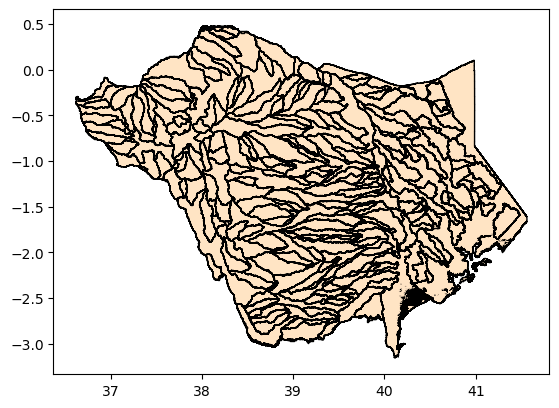

In [6]:

shape_file = os.path.join(shape_path, '*.gpkg')
shape_files = glob.glob(shape_file)
print(shape_file)
gdfs = []

for file in shape_files:
    gdf = gpd.read_file(file)
    gdfs.append(gdf)

merged_gdfs = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
merged_gdfs.plot(color = 'bisque', edgecolor = 'black')

In [ ]:
#gdfs

In [ ]:
execute = False

if (execute == True):
    def clip_netCDF_to_geopackage(netCDF_file, geopackage_file):
        # Open the GeoPackage file
        geopackage_gdf = gpd.read_file(geopackage_file)

        # Open the NetCDF file
        with rasterio.open(netCDF_file) as src:
            # Read the NetCDF data
            data = src.read(1)

            # Clip the NetCDF data to the GeoPackage boundaries
            clipped_data, _ = mask(src, geopackage_gdf.geometry, crop=True, nodata=np.nan)

            # Get metadata for the clipped data
            meta = src.meta.copy()

        return clipped_data, meta

    # Example usage:
    i = 0
    start_time = time.time()
    clipped_data = []

    netCDF_file = data_files[0]  # Assuming data_files contains the list of NetCDF file paths
    for geopackage_file in shape_files:  # Assuming shape_files is a list of GeoPackage file paths
        clipped_data_current, meta = clip_netCDF_to_geopackage(netCDF_file, geopackage_file)
        clipped_data.append(clipped_data_current)
        print(geopackage_file)
        i += 1
        if i > 10:
            break;
        print(clipped_data_current.shape)
    # clipped_data, meta = clip_netCDF_to_geopackage(chirps_file, shape_files)
    end_time = time.time()

    # Calculate and print the execution time
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

In [ ]:
# Trying to add the precipitation and location data to the clipped shapefiles
execute = True


if (execute == True):
    def clip_netCDF_to_geopackage(netCDF_file, geopackage_file):
        # Obtain the name of the shapefile from the GeoPackage file
        shapefile_name = os.path.basename(geopackage_file)

        # Open the GeoPackage file
        geopackage_gdf = gpd.read_file(geopackage_file)
        geopackage_gdf = geopackage_gdf.to_crs('EPSG:4326')
        

        #geopackage_gdf = geopackage_gdf.to_crs('EPSG:32737')
        # Open the NetCDF file
        with rasterio.open(netCDF_file) as src:
            # Read the entire timeseries data
            data = src.read()

            # Clip the NetCDF data to the GeoPackage boundaries
            clipped_data, transform = mask(src, geopackage_gdf.geometry, crop=True, nodata=np.nan)
            #clipped_data_evap, transform_evap = mask(src_evap, geopackage_gdf_evap.geometry, crop=True, nodata=np.nan)
            
            # Calculate the area of each clipped geometry
            averaged_clipped_data = np.nanmean(clipped_data, axis=(1, 2)) 
            
            
            

            clipped_areas = geopackage_gdf.geometry.area
            
            # Create an xarray Dataset from the clipped data
            '''clipped_dataset = xr.DataArray(
                clipped_data,
                dims=["time", "y", "x"],
                coords={"time": np.arange(clipped_data.shape[0]), "y": np.arange(clipped_data.shape[1]), "x": np.arange(clipped_data.shape[2])}
            ).to_dataset(name="precipitation")'''
            
            clipped_dataset = xr.DataArray(
                averaged_clipped_data,
                dims=["time"],
                coords={"time": np.arange(averaged_clipped_data.shape[0])}
            ).to_dataset(name="precipitation")

                # Add the clipped areas as a new coordinate variable to the dataset
            clipped_dataset.coords['area_m2'] = (('gdf'), clipped_areas)
            
            average_evap_da = xr.DataArray([average_evap] * clipped_dataset.dims['time'], dims=["time"], coords={"time": clipped_dataset.coords["time"]})

            # Add this DataArray to your existing dataset as a new variable
            clipped_dataset['average_evap'] = average_evap_da

        return {shapefile_name: clipped_dataset}



    # Assuming data_files and shape_files are already defined
    dataset_list = []
    i = 0
    average_evap = 0.41639290443606647

    # Remove the break condition to process all shapefiles
    netCDF_file = data_files[0]
    start_time = time.time()
    for geopackage_file in shape_files:
        clipped_dataset = clip_netCDF_to_geopackage(netCDF_file, geopackage_file)
        #clipped_dataset = clip_netCDF_to_geopackage(netCDF_file_evap, geopackage_file, area = False)
        dataset_list.append(clipped_dataset)
        i  += 1
        if i > 2:
            break
        print('Processing:', geopackage_file)
    

    
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")
    # Combine all datasets into one (if necessary and feasible)
    # combined_dataset = xr.concat(dataset_list, dim='gdf')

In [ ]:
print(dataset_list[1])
has_non_nan = dataset_list[0]['fid_413.gpkg']['precipitation'].notnull().any()

print("Are there any non-NaN values in the precipitation array?", has_non_nan.values)
#clipped_dataset['fid_413.gpkg']['precipitation']


In [ ]:



for dataset_dict in dataset_list:
    for key, ds in dataset_dict.items():
        filename = f"{key.replace('.gpkg', '')}.nc"  # Creating a filename for each dataset
        file_location = os.path.join(data_path, filename)
        ds.to_netcdf(file_location)
     


geopackage_gdf = gpd.read_file(geopackage_file)
print(geopackage_gdf.crs)
geopackage_gdf = geopackage_gdf.to_crs('EPSG:4326')
print(geopackage_gdf.crs)

print('shapes')


In [ ]:
'''def clip_netCDF_to_geopackage(netCDF_file, geopackage_file, netCDF_file_evap):
    # Obtain the name of the shapefile from the GeoPackage file
    shapefile_name = os.path.basename(geopackage_file)

    # Open the GeoPackage file
    geopackage_gdf = gpd.read_file(geopackage_file)

    # Open the NetCDF file for precipitation
    with rasterio.open(netCDF_file) as src:
        # Read the entire timeseries data for precipitation
        data = src.read()
        # Clip the NetCDF data to the GeoPackage boundaries
        clipped_data, transform = mask(src, geopackage_gdf.geometry, crop=True, nodata=np.nan)

    # Open the NetCDF file for evaporation
    with rasterio.open(netCDF_file_evap) as src_evap:
        # Read the entire timeseries data for evaporation
        data_evap = src_evap.read()
        # Clip the NetCDF data to the GeoPackage boundaries
        clipped_data_evap, transform_evap = mask(src_evap, geopackage_gdf_evap.geometry, crop=True, nodata=np.nan)

    # Create xarray DataArrays from the clipped data
    precipitation_da = xr.DataArray(
        clipped_data,
        dims=["time", "y", "x"],
        coords={"time": np.arange(clipped_data.shape[0]), "y": np.arange(clipped_data.shape[1]), "x": np.arange(clipped_data.shape[2])},
        name="precipitation"
    )

    evaporation_da = xr.DataArray(
        clipped_data_evap,
        dims=["time", "y", "x"],
        coords={"time": np.arange(clipped_data_evap.shape[0]), "y": np.arange(clipped_data_evap.shape[1]), "x": np.arange(clipped_data_evap.shape[2])},
        name="evaporation"
    )

    # Combine the DataArrays into a single Dataset
    clipped_dataset = xr.merge([precipitation_da, evaporation_da])

    return {shapefile_name: clipped_dataset}

dataset_list = []
i = 0

# Remove the break condition to process all shapefiles
netCDF_file = data_files[0]
start_time = time.time()
for geopackage_file in shape_files:
    clipped_dataset = clip_netCDF_to_geopackage(netCDF_file, geopackage_file, dataset_evap)
    #clipped_dataset = clip_netCDF_to_geopackage(netCDF_file_evap, geopackage_file, area = False)
    dataset_list.append(clipped_dataset)
    i  += 1
    if i > 1:
        break
    print('Processing:', geopackage_file)

end_time = time.time()
execution_time = end_time - start_time
'''
x=5

In [ ]:
# shapefile_name = os.path.splitext(os.path.basename(geopackage_file))[0]
clipped_dataset['fid_1027.gpkg']['precipitation']


In [ ]:
def get_shapefile_names(folder_path):
    shapefile_names = [file for file in os.listdir(folder_path) if file.endswith('.gpkg')]
    return shapefile_names
shapefile_name = get_shapefile_names(shape_path)
shapefile_name

In [ ]:
mini_shape_path = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data', 'Shapefiles', 'Mini_shapes')
mini_shape_file = os.path.join(mini_shape_path, '*.gpkg')
mini_shape_files = glob.glob(mini_shape_file)
gdfs_mini = []

print(mini_shape_files)

for file in mini_shape_files:
    gdf_mini = gpd.read_file(file)
    gdfs_mini.append(gdf_mini)

merged_gdfs_mini = gpd.GeoDataFrame(pd.concat(gdfs_mini, ignore_index=True))
merged_gdfs_mini.plot(color = 'bisque', edgecolor = 'black')

In [ ]:
# select one day from the chirps file

mini_1_file = mini_shape_files[100]
mini_1_shape = gpd.read_file(mini_1_file)
mini_1_shape.plot(color= 'bisque')
ds = xr.open_dataset(data_files[0])
ds_day_1 = ds.sel(time = '2018-01-01') # --> Selected day
# print(mini_1_shape)
shape_1 = gpd.read_file(mini_shape_files[0])

clip_1 = shape_1.geometry.values[0]

# print(clip_1)


# with rasterio.open(data_files[0]) as src:
#     # Clip the dataset to the clipping geometry
#     clipped_mini_data, clipped_transform = mask(src, [clip_1], crop=True)

# print(clipped_mini_data)

# geopackage_gdf = gpd.read_file(mini_1_shape)
# clipped_mini, _ = mask(src, geopackage_gdf.geometry.values[0], crop = True, nodata=np.nan)

In [ ]:
ds = xr.open_dataset(data_files[0])  # Assuming data_files contains the list of NetCDF file paths
ds_day_1 = ds.sel(time='2018-01-01')  # Selected day

# Load the GeoPackage shapefile
shape_1 = gpd.read_file(mini_shape_files[0])  # Assuming mini_shape_files contains the path to the shapefile
clip_1 = shape_1.geometry.values[0]  # Assuming the shapefile has only one geometry

# Open the CHIRPS file with rasterio
with rasterio.open(data_files[0]) as src:
    # Clip the CHIRPS data to the clipping geometry
    clipped_mini, _ = mask(src, [clip_1], crop=True, nodata=np.nan)

plt.imshow(clipped_mini, cmap='jet')
plt.colorbar(label='Precipitation (mm)')
plt.title('Clipped CHIRPS Data')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()
